In [1]:
#pip install imageio

In [1]:
##This is a framework of patch-based hyperspectral classification
import os
import time
import random
import spectral
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib.patches as mpts
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from sklearn.preprocessing import minmax_scale
from scipy.io import loadmat
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
##hypeperameters and experimental settings
RANDOM_SEED=666
MODEL_NAME = 'ConvKAN' ## your model name
DATASET = 'Pingan'  ## PU  IP  SA or your personal dataset
TRAIN_RATE = 0.3  ## ratio of training data
VAL_RATE = 0.2    ## ratio of valuating data
EPOCH = 5    ##number of epoch
VAL_EPOCH = 1  ##interval of valuation
LR = 0.001    ##learning rate
WEIGHT_DECAY = 1e-6  
BATCH_SIZE = 64
DEVICE = 0  ##-1:CPU  0:cuda 0
N_PCA = 15  ## reserved PCA components   0:use origin data
NORM = True  ## normalization or not
PATCH_SIZE = 8 ## patchsize of input 3D cube   1:only spectral sequence
CHECK_POINT = None  ## path of check point model

SAVE_PATH = f"E:/Roy/Sim Pool/Results\\{MODEL_NAME}\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [3]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def loadData(name): ## customize data and return data label and class_name
    data_path = os.path.join(os.getcwd(),'E:/Roy/Sim Pool/Data/')
    if name == 'Tangdaowan':
        data = loadmat(os.path.join(data_path, 'QUH-Tangdaowan.mat'))['Tangdaowan']
        labels = loadmat(os.path.join(data_path, 'QUH-Tangdaowan_GT.mat'))['TangdaowanGT']
        class_name = [     "Rubber track",    "Flaggingv",    "Sandy",    "Asphalt",    "Boardwalk",    "Rocky shallows",    "Grassland",
    "Bulrush",    "Gravel road",    "Ligustrum vicaryi",    "Coniferous pine",    "Spiraea",    "Bare soil",    "Buxus sinica",    "Photinia serrulata",
    "Populus",    "Ulmus pumila L",    "Seawater"]
    
    elif name == 'Qingyun':
        data = loadmat(os.path.join(data_path, 'QUH-Qingyun.mat'))['Chengqu']
        labels = loadmat(os.path.join(data_path, 'QUH-Qingyun_GT.mat'))['ChengquGT']
        class_name = ["Trees", "Concrete building", "Car", "Ironhide building", "Plastic playground", "Asphalt road"]
    
    elif name == 'Pingan':
        data = loadmat(os.path.join(data_path, 'QUH-Pingan.mat'))['Haigang']
        labels = loadmat(os.path.join(data_path, 'QUH-Pingan_GT.mat'))['HaigangGT']
        class_name = ["Ship", "Seawater", "Trees"," Concrete structure building", "Floating pier", "Brick houses", 
                      "Steel houses"," Wharf construction land", "Car", "Road"]
    return data, labels, class_name


In [6]:
data,label,class_name = loadData(DATASET)
NUM_CLASS = label.max()

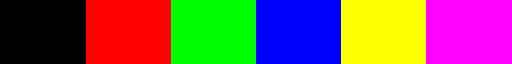

In [7]:
a = data[:,:,[1,2,3]]
cmap=plt.matplotlib.colors.ListedColormap(spectral.spy_colors/255,'Classification',6)
cmap

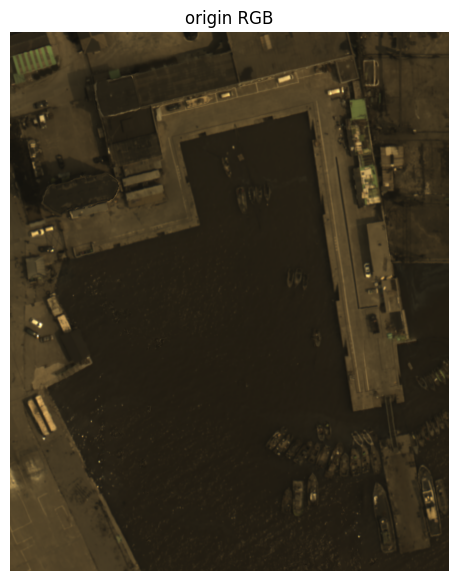

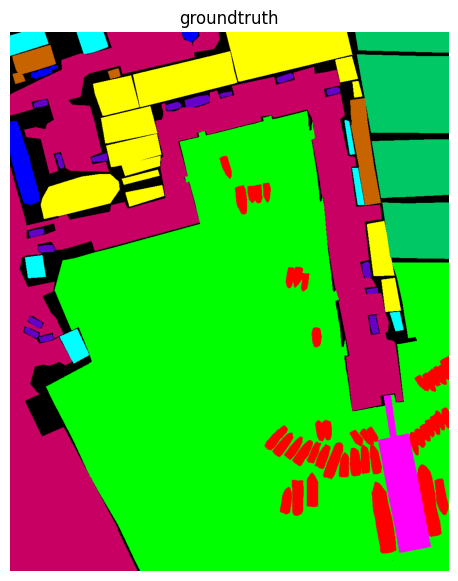

In [8]:
def img_display(data = None, rgb_band = None, classes = None,class_name = None,title = None, 
                figsize = (7,7),palette = spectral.spy_colors):
    if data is not None:
        im_rgb = np.zeros_like(data[:,:,0:3])
        im_rgb = data[:,:,rgb_band]
        im_rgb = im_rgb/(np.max(np.max(im_rgb,axis = 1),axis = 0))*255
        im_rgb = np.asarray(im_rgb,np.uint8)
        fig, rgbax = plt.subplots(figsize = figsize)
        rgbax.imshow(im_rgb)
        rgbax.set_title(title)
        rgbax.axis('off')
        
    elif classes is not None:
        rgb_class = np.zeros((classes.shape[0],classes.shape[1],3))
        for i in np.unique(classes):
            rgb_class[classes==i]=palette[i]
        rgb_class = np.asarray(rgb_class, np.uint8)
        _,classax = plt.subplots(figsize = figsize)
        classax.imshow(rgb_class)
        classax.set_title(title)
        classax.axis('off')
        # rect = [mpts.Rectangle((0,0),1,1,facecolor=palette[i]/255) for i in range(len(class_name))]
        # classax.legend(rect,class_name,bbox_to_anchor = (1.04,1),frameon=False,loc = 'upper left')
        
img_display(data,(30,20,10),title='origin RGB')
img_display(classes=label,title='groundtruth',class_name=class_name)

In [9]:
# ## display HSI
# rgb_view=spectral.imshow(data,(30,20,10),classes=label.astype(int),title='RGB origin',figsize=(7,7))
# gt_view = spectral.imshow(classes=label.astype(int), title='GroundTruth',figsize=(7,7))
# view = spectral.imshow(data,(30,20,10),classes=label.astype(int),figsize=(7,7))
# view.set_display_mode('overlay')
# view.set_title('Overlay')
spectral.save_rgb(f'E:/Roy/Sim Pool/Results/{DATASET}_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'E:/Roy/Sim Pool/Results/{DATASET}_gt.jpg',label,colors = spectral.spy_colors)

In [10]:
def applyPCA(X, numComponents=15, norm = True):
    """PCA and processing
    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional):  number of reserved components(Defaults to 15, 0 for no PCA).
        norm: normalization or not
    Returns:
        newX: processed data
        pca: 
    """
    
    if numComponents == 0:
        newX = np.reshape(X, (-1, X.shape[2]))
    else:
        newX = np.reshape(X, (-1, X.shape[2]))
        pca = PCA(n_components=numComponents)   ##PCA and normalization
        newX = pca.fit_transform(newX)
    if norm:
        newX = minmax_scale(newX, axis=1)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], -1))
    return newX, newX.shape[2]

In [11]:
data,N_PCA = applyPCA(data, N_PCA, NORM)
data.shape,N_PCA

((1230, 1000, 15), 15)

In [12]:
def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap
        train_rate (float): ratio of training dataset
    Returns:
        train_gt(ndarray): classmap of training data
        test_gt(ndarray): classmap of test data
    """
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
    y = gt[indices].ravel()
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    if train_rate > 1:
       train_rate = int(train_rate)
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    
    return train_gt, test_gt

In [13]:
train_gt, test_gt = sample_gt(label,TRAIN_RATE)
val_gt,test_gt = sample_gt(test_gt,VAL_RATE/(1-TRAIN_RATE))

          class          train_num  val_num   test_num   total   
          Ship             14680      9787     24468     48935   
        Seawater           173434    115622    289057    578113  
          Trees             2504      1669      4172      8345   
 Concrete structure building  26692     17794     44487     88973   
      Floating pier         6228      4152     10379     20759   
      Brick houses          4226      2817      7043     14086   
      Steel houses          4197      2798      6996     13991   
 Wharf construction land   24934     16623     41556     83113   
           Car              2432      1622      4054      8108   
          Road             82954     55303     138257    276514  
          total            342281    228187    570469   1140937  


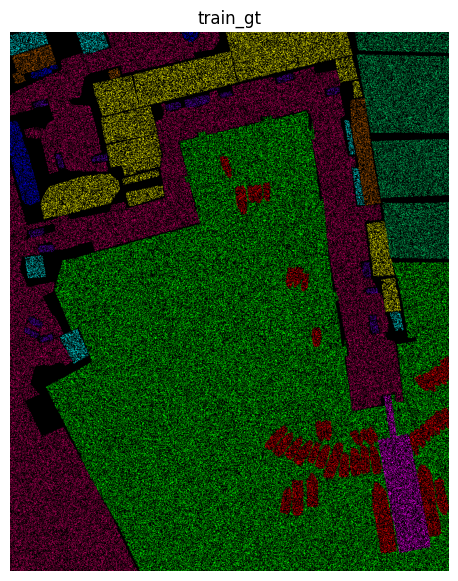

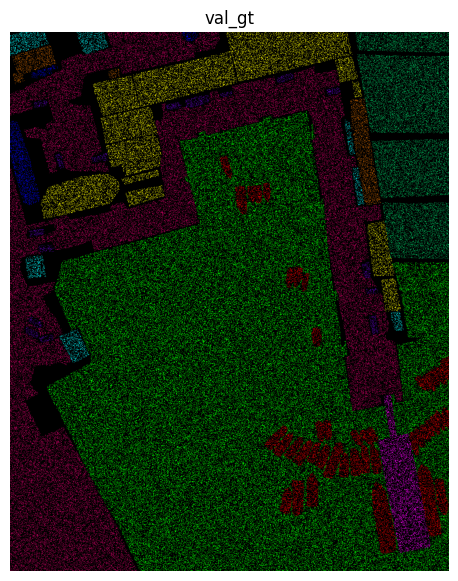

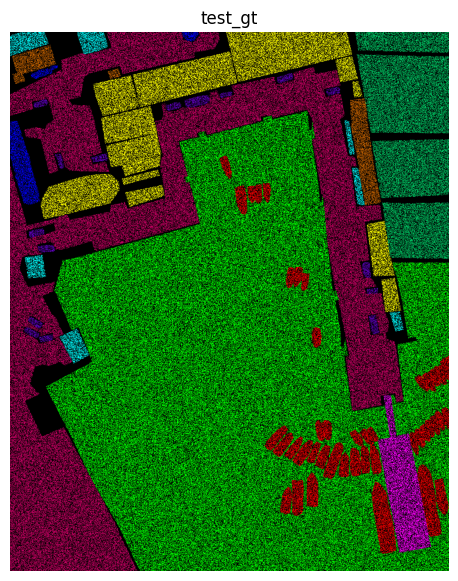

In [14]:
## display sampling info
sample_report = f"{'class': ^25}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{class_name[i-1]: ^25}{(train_gt==i).sum(): ^10}{(val_gt==i).sum(): ^10}{(test_gt==i).sum(): ^10}{(label==i).sum(): ^10}\n"
sample_report += f"{'total': ^25}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"
print(sample_report)
img_display(classes=train_gt,title='train_gt')
img_display(classes=val_gt,title='val_gt')
img_display(classes=test_gt,title='test_gt')

# spectral.imshow(classes=train_gt, title='train_gt')
# spectral.imshow(classes=val_gt, title='val_gt')
# spectral.imshow(classes=test_gt, title='test_gt')

In [15]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 
        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label


In [16]:
##create dataset and dataloader
train_data = PatchSet(data, train_gt, PATCH_SIZE)
val_data = PatchSet(data, val_gt, PATCH_SIZE)
all_data = PatchSet(data, label, PATCH_SIZE,is_pred = True)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
all_loader = DataLoader(all_data,BATCH_SIZE,shuffle= False)

In [17]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([15, 8, 8]), tensor(2))

In [18]:
#pip install unfoldNd

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from ConvKAN import ConvKAN
from ConvKAN3D import effConvKAN3D


In [20]:




class Net(nn.Module):
    # Define the architecture of the network
    def __init__(self):
        super(Net, self).__init__()
        
        # 3 input image channel (3 colour channels)
        # 6 output channels,
        # 3x3 square convolution kernel
        #self.conv1 = nn.Conv2d(15, 32, 1)

       
        
        self.ConvKAN1 = ConvKAN(in_channels=15, out_channels=8, kernel_size=1, stride=1, padding=1, version="Fast")
        # 3x3 square convolution kernel
        #self.conv2 = nn.Conv2d(32, 64, 3)
        self.ConvKAN2 = ConvKAN(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, version="Fast")
        # Max pooling over a (3, 3) window
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        #self.conv3 = nn.Conv2d(64, 64, 3)
        self.ConvKAN3 = ConvKAN(in_channels=16, out_channels=4, kernel_size=3, stride=1, padding=1, version="Fast")
        # 5*5 from image dimension
        self.fc1 = nn.Linear(4 * 4* 4 , 32)
        self.fc2 = nn.Linear(32, 25)
        self.fc3 = nn.Linear(25, NUM_CLASS)

    # Set the flow of data through the network for the forward pass
    # x represents the data
    def forward(self, x):
        # F.relu is the rectified-linear activation function
        
        x = self.ConvKAN1(x)
        x = self.pool(self.ConvKAN2(x))
        x = self.ConvKAN3(x)
        
        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        
        return output

In [21]:
#instantiate CNN model
model = Net()
model

Net(
  (ConvKAN1): ConvKAN(
    (unfold): Unfold(kernel_size=1, dilation=1, padding=1, stride=1)
    (linear): Fast_KANLinear(
      (layernorm): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=75, out_features=8, bias=False)
      (base_activation): SiLU()
      (base_linear): Linear(in_features=15, out_features=8, bias=True)
    )
  )
  (ConvKAN2): ConvKAN(
    (unfold): Unfold(kernel_size=3, dilation=1, padding=1, stride=1)
    (linear): Fast_KANLinear(
      (layernorm): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=360, out_features=16, bias=False)
      (base_activation): SiLU()
      (base_linear): Linear(in_features=72, out_features=16, bias=True)
    )
  )
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ConvKAN3): ConvKAN(
    (unfold): Unfold(kernel_size=3, dila

In [22]:
torch.cuda.is_available()

True

In [24]:
from torchsummary import summary
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')
summary(model.to(device),(15, 8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Unfold-1              [-1, 15, 100]               0
         LayerNorm-2                   [-1, 15]              30
RadialBasisFunction-3                [-1, 15, 5]               0
      SplineLinear-4                    [-1, 8]             600
              SiLU-5                   [-1, 15]               0
              SiLU-6                   [-1, 15]               0
              SiLU-7                   [-1, 15]               0
            Linear-8                    [-1, 8]             128
    Fast_KANLinear-9                    [-1, 8]               0
          ConvKAN-10            [-1, 8, 10, 10]               0
           Unfold-11              [-1, 72, 100]               0
        LayerNorm-12                   [-1, 72]             144
RadialBasisFunction-13                [-1, 72, 5]               0
     SplineLinear-14                

In [22]:
EPOCH = 100


## training the model
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')

loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []
epoch_start = 0

model = model ##modify to you model 
#model.to(device)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)


if CHECK_POINT is not None:
    
    model_ckpt = torch.load(CHECK_POINT,map_location = device)
    model.load_state_dict(model_ckpt['state_dict'])
    epoch_start = model_ckpt['epoch']
    optimizer.load_state_dict(model_ckpt['optimizer'])
    loss_list = model_ckpt['loss_list']
    acc_list = model_ckpt['acc_list']
    val_acc_list = model_ckpt['val_acc_list']
    val_epoch_list = model_ckpt['val_epoch_list']

loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = val_loader.dataset.__len__()
train_st = time.time()
run_error = False

try:
    for e in tqdm(range(epoch_start,EPOCH), desc="Training:"):
        
        model.train()
        avg_loss = 0.
        train_acc = 0
        
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            
            data,target = data,target
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            
            val_acc =0
            model.eval()
            
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                
                data,target = data,target
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            save_dict = {'state_dict':model.state_dict(), 'epoch':e+1, 'optimizer': optimizer.state_dict(),
                        'loss_list':loss_list, 'acc_list': acc_list, 'val_acc_list': val_acc_list, 'val_epoch_list':val_epoch_list}
            torch.save(save_dict,save_name)

except Exception as exc:
    print(exc)
    run_error = True
finally: 
    print(f'Stop in epoch {e}')
train_time = time.time()-train_st
print(f"training time: {train_time}")

Training::   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 0/100 loss:0.0051888390958379615  acc:0.889438794440825


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 0/100  val_acc:0.9186851135253103


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 1/100 loss:0.0033915000281367676  acc:0.9260958101676693


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 1/100  val_acc:0.9320864028187408


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 2/100 loss:0.002907121895749525  acc:0.9357311682506478


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 2/100  val_acc:0.930215130572732


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 3/100 loss:0.002590321778835362  acc:0.9425822642799337


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 3/100  val_acc:0.9473239053933835


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 4/100 loss:0.0023718391335104654  acc:0.9472158840251139


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 4/100  val_acc:0.948502763084663


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 5/100 loss:0.0022101562858523336  acc:0.9510226977249686


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 5/100  val_acc:0.9522190133530832


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 6/100 loss:0.0020851848977354657  acc:0.9538215676593208


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 6/100  val_acc:0.954931700754206


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 7/100 loss:0.0019720744299456497  acc:0.9563633388940666


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 7/100  val_acc:0.9554838794497496


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 8/100 loss:0.001900967349018399  acc:0.9573566747789097


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 8/100  val_acc:0.9531743701437856


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 9/100 loss:0.0018085913915332483  acc:0.9594952685074544


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 9/100  val_acc:0.9601160451734762


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 10/100 loss:0.0017435943431371843  acc:0.9608216640713332


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 10/100  val_acc:0.9573726811781565


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 11/100 loss:0.0016835731591127105  acc:0.9622912168656746


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 11/100  val_acc:0.9573069456191632


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 12/100 loss:0.0016404684912868298  acc:0.9635883966682346


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 12/100  val_acc:0.9594280129893464


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 13/100 loss:0.0015980118663099644  acc:0.9640850646106561


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 13/100  val_acc:0.9638410601830955


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 14/100 loss:0.0015408872538418164  acc:0.9657036177877241


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 14/100  val_acc:0.9560360581452931


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 15/100 loss:0.0015119122770421284  acc:0.9663638939935316


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 15/100  val_acc:0.9567679140354183


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 16/100 loss:0.001471857683278645  acc:0.9668079735655791


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 16/100  val_acc:0.963218763557959


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 17/100 loss:0.0014328230612846219  acc:0.9679240156479617


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 17/100  val_acc:0.9654713020461289


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 18/100 loss:0.0013977210795672176  acc:0.9683943894051963


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 18/100  val_acc:0.960606870680626


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 19/100 loss:0.0013710384395726975  acc:0.9691510776233563


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 19/100  val_acc:0.9660322454828715


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 20/100 loss:0.0013518032350792086  acc:0.9690546656110038


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 20/100  val_acc:0.9690429340847638


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 21/100 loss:0.001323382258779405  acc:0.9704950026440264


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 21/100  val_acc:0.9639418547068851


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 22/100 loss:0.0012918161774774085  acc:0.9708339054753258


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 22/100  val_acc:0.9659139214766836


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 23/100 loss:0.0012788388757955403  acc:0.971181573035021


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 23/100  val_acc:0.9636876772121111


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 24/100 loss:0.0012565688296127457  acc:0.9717746529897949


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 24/100  val_acc:0.9678991353582808


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 25/100 loss:0.0012516252172941932  acc:0.9715759858128263


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 25/100  val_acc:0.9629339094689882


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 26/100 loss:0.0012202977189205602  acc:0.9726920278952089


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 26/100  val_acc:0.9710675893017569


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 27/100 loss:0.0012020399458922834  acc:0.9725985374589884


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 27/100  val_acc:0.9705592343122088


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 28/100 loss:0.001175329263481782  acc:0.9735217555166661


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 28/100  val_acc:0.9688544921489831


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 29/100 loss:0.001167883650558508  acc:0.9736795206277883


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 29/100  val_acc:0.971545267697108


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 30/100 loss:0.0011472768412064927  acc:0.9738869525331526


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 30/100  val_acc:0.9683023134534395


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 31/100 loss:0.001153415519580211  acc:0.9738285210105148


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 31/100  val_acc:0.9728468317651751


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 32/100 loss:0.001131339749775775  acc:0.9743748557471785


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 32/100  val_acc:0.9702656154820388


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 33/100 loss:0.0011220761018007992  acc:0.9746903859694228


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 33/100  val_acc:0.9727285077589871


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 34/100 loss:0.0010920052526673706  acc:0.9751841323357124


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 34/100  val_acc:0.9713480610201283


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 35/100 loss:0.0010927364541061628  acc:0.9751373871176022


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 35/100  val_acc:0.968972816155171


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 36/100 loss:0.001068237989846924  acc:0.9756311334838919


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 36/100  val_acc:0.9734998049845083


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 37/100 loss:0.0010845101035529762  acc:0.9753360542945708


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 37/100  val_acc:0.9735480110611034


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 38/100 loss:0.0010694888089695413  acc:0.9757158591917168


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 38/100  val_acc:0.9657955974704957


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 39/100 loss:0.001052739331325963  acc:0.9761540956115005


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 39/100  val_acc:0.9718213570448798


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 40/100 loss:0.0010413897272464718  acc:0.9767734697514615


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 40/100  val_acc:0.9720799169102534


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 41/100 loss:0.001017682384775014  acc:0.9768523523070226


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 41/100  val_acc:0.9745953976343964


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 42/100 loss:0.0010204782579382836  acc:0.9769867448090896


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 42/100  val_acc:0.9727416548707858


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 43/100 loss:0.001015698810642613  acc:0.9771970982905858


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 43/100  val_acc:0.9736575703260922


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 44/100 loss:0.0010001696734286628  acc:0.977489255903775


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 44/100  val_acc:0.971115795378352


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 45/100 loss:0.0009967592260203446  acc:0.977436667533401


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 45/100  val_acc:0.9714882968793139


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 46/100 loss:0.0009879281942853093  acc:0.9777054525375349


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 46/100  val_acc:0.9733990104607186


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 47/100 loss:0.0009701745593409332  acc:0.9780735711301533


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 47/100  val_acc:0.9731798919307411


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 48/100 loss:0.0009682246244109711  acc:0.9781407673811868


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 48/100  val_acc:0.9732105685249379


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 49/100 loss:0.0009640014391122934  acc:0.9781729047186376


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 49/100  val_acc:0.9751300468475417


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 50/100 loss:0.0009440495122188348  acc:0.9787513767927521


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 50/100  val_acc:0.9745822505225977


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 51/100 loss:0.0009448634100355755  acc:0.9789938676116992


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 51/100  val_acc:0.9747181040111839


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 52/100 loss:0.0009591637792841184  acc:0.9782926893400452


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 52/100  val_acc:0.9707739704715869


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 53/100 loss:0.0009386104834390285  acc:0.9787893572824667


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 53/100  val_acc:0.9754455775307095


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 54/100 loss:0.0009250457836901545  acc:0.9791165738092386


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 54/100  val_acc:0.9722639764754346


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 55/100 loss:0.0009129951288111967  acc:0.9794437903360105


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 55/100  val_acc:0.9756208723546915


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 56/100 loss:0.0009009903694501514  acc:0.9796687516981661


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 56/100  val_acc:0.9746173094873941


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 57/100 loss:0.00090238133650061  acc:0.9795869475664731


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 57/100  val_acc:0.9736619526966918


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 58/100 loss:0.0009008062001789769  acc:0.9796103201755283


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 58/100  val_acc:0.9718958573450722


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 59/100 loss:0.0008870620404785077  acc:0.9802150864348299


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 59/100  val_acc:0.9749240754293628


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 60/100 loss:0.0008906059326099708  acc:0.980238459043885


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 60/100  val_acc:0.9755332249427004


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 61/100 loss:0.0008873068766461336  acc:0.9799813603442785


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 61/100  val_acc:0.9739117478208662


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 62/100 loss:0.000891813274574302  acc:0.9797622421343867


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 62/100  val_acc:0.9759670796320562


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 63/100 loss:0.0008734980733218726  acc:0.9801157528463456


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 63/100  val_acc:0.9763746400978145


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 64/100 loss:0.0008713172870716799  acc:0.9802764395335996


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 64/100  val_acc:0.9707126172831931


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 65/100 loss:0.0008596071956725554  acc:0.9807789506282849


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 65/100  val_acc:0.9748495751291704


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 66/100 loss:0.0008481256102828589  acc:0.9808549116077141


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 66/100  val_acc:0.976243168979828


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 67/100 loss:0.000860542710526868  acc:0.9803816162743477


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 67/100  val_acc:0.9719835047570633


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 68/100 loss:0.0008516633457154348  acc:0.9807117543772514


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 68/100  val_acc:0.9770889665055416


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 69/100 loss:0.000841675848916419  acc:0.9811383044925076


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 69/100  val_acc:0.9778295871368659


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 70/100 loss:0.000834933795061473  acc:0.9810448140562871


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 70/100  val_acc:0.9655414199757216


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 71/100 loss:0.000842725480188277  acc:0.9811383044925076


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 71/100  val_acc:0.9692094641675468


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 72/100 loss:0.0008223973480500225  acc:0.9814100110727736


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 72/100  val_acc:0.9751694881829377


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 73/100 loss:0.0008297850710568262  acc:0.981290226451366


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 73/100  val_acc:0.9764009343214118


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 74/100 loss:0.000832893760632401  acc:0.981290226451366


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 74/100  val_acc:0.9781845591554296


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 75/100 loss:0.0008218344761398121  acc:0.9815794624884232


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 75/100  val_acc:0.9695030829977168


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 76/100 loss:0.0008248956024594781  acc:0.9813048343320254


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 76/100  val_acc:0.973101009259949


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 77/100 loss:0.0008122584330799985  acc:0.9819212868958546


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 77/100  val_acc:0.9752264590007319


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 78/100 loss:0.0008104398947205324  acc:0.981614521402006


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 78/100  val_acc:0.9758619027376669


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 79/100 loss:0.0008042102053096693  acc:0.9817372275995454


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 79/100  val_acc:0.9773212321473178


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 80/100 loss:0.0008049782740026498  acc:0.9820030910275476


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 80/100  val_acc:0.9758005495492732


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 81/100 loss:0.0008044557681225169  acc:0.9817956591221833


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 81/100  val_acc:0.9764359932862082


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 82/100 loss:0.0007907152283806044  acc:0.9822923270646048


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 82/100  val_acc:0.9778734108428614


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 83/100 loss:0.0007888395028537386  acc:0.9821579345625377


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 83/100  val_acc:0.9701429091052514


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 84/100 loss:0.0007797593662540242  acc:0.9825523473403431


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 84/100  val_acc:0.9773825853357115


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 85/100 loss:0.0007761499072924304  acc:0.9823010917930005


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 85/100  val_acc:0.9721281229868485


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 86/100 loss:0.0007796197341450904  acc:0.9826458377765637


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 86/100  val_acc:0.9781714120436309


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 87/100 loss:0.0007842000172770373  acc:0.982584484677794


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 87/100  val_acc:0.9740300718270541


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 88/100 loss:0.0007766098633922402  acc:0.9825757199493983


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 88/100  val_acc:0.9766463470749868


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 89/100 loss:0.0007758561160097139  acc:0.9823566017395065


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 89/100  val_acc:0.9785702077681901


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 90/100 loss:0.0007593707429602842  acc:0.9828766422909831


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 90/100  val_acc:0.9760328151910495


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 91/100 loss:0.00076773576317809  acc:0.982637073048168


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 91/100  val_acc:0.9762300218680293


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 92/100 loss:0.0007657301684519179  acc:0.9829672111510718


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 92/100  val_acc:0.9769180540521589


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 93/100 loss:0.0007646255443206053  acc:0.9827364066366523


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 93/100  val_acc:0.9748539574997699


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 94/100 loss:0.0007543662287107259  acc:0.9830314858259734


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 94/100  val_acc:0.9760591094146468


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 95/100 loss:0.0007554938637105807  acc:0.9831220546860621


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 95/100  val_acc:0.977798910542669


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 96/100 loss:0.0007580547826264302  acc:0.9830869957724794


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 96/100  val_acc:0.9781188235964362


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 97/100 loss:0.0007494025374416033  acc:0.9830110347930502


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 97/100  val_acc:0.9753579301187184


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 98/100 loss:0.0007425075457927735  acc:0.9833587023527453


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 98/100  val_acc:0.9758925793318638


  0%|          | 0/5349 [00:00<?, ?it/s]

epoch 99/100 loss:0.0007338255887161712  acc:0.9836070363239561


  0%|          | 0/3566 [00:00<?, ?it/s]

epoch 99/100  val_acc:0.975322871153922
Stop in epoch 99
training time: 57740.73063182831


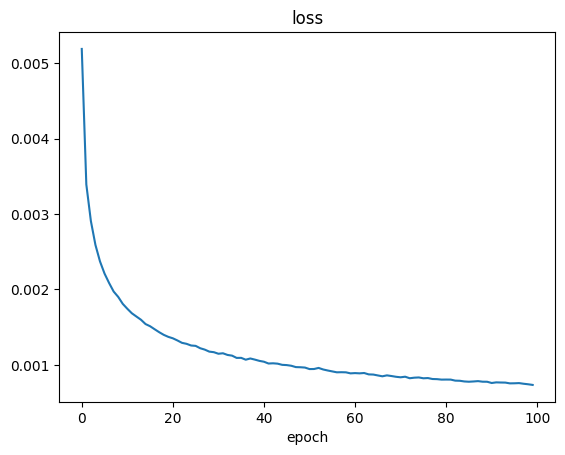

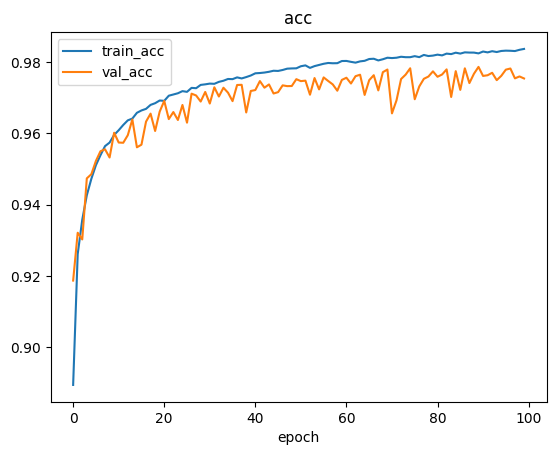

In [23]:
##display loss and acc
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax2 = fig2.add_subplot(1,1,1)
ax1.plot(np.arange(e+1),loss_list)
ax1.set_title('loss')
ax1.set_xlabel('epoch')
ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
ax2.set_title('acc')
ax2.set_xlabel('epoch')
ax2.legend()

In [24]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path, del_others = True):
    """get best model path by valuation list
    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir
    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    if del_others:
        for f in os.listdir(save_path):
            if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
                os.remove(os.path.join(save_path,f))
    return best_model_path

In [25]:
# save
PATH = 'E:/Roy/Sim Pool/Results/Training/ConvKAN_Pingan_30.pth'
torch.save(model.state_dict(), PATH)
# reload


best model:epoch_89_acc_0.9786.pth


  0%|          | 0/19219 [00:00<?, ?it/s]

inferring time: 636.1953399181366


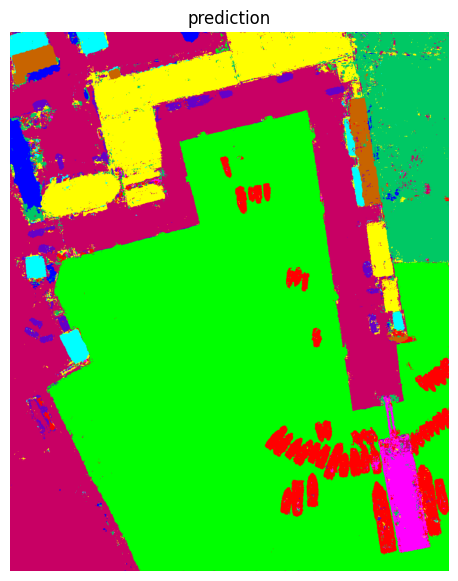

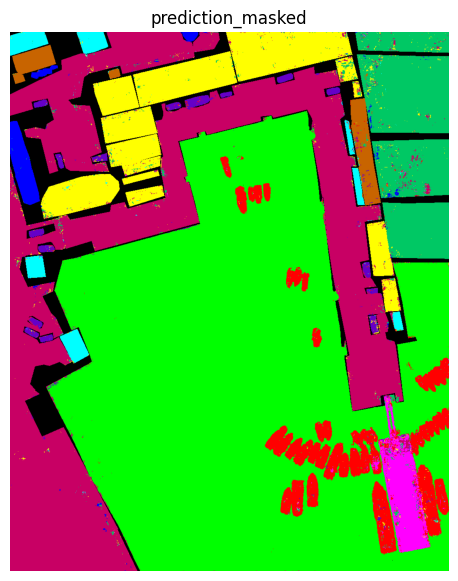

In [26]:
## inferring the whole image
##load best model
best_model_path = get_best_model(val_acc_list,val_epoch_list,SAVE_PATH, not run_error)

best_model = model  ## modify to your model

best_model.load_state_dict(torch.load(best_model_path)['state_dict'])
## inference
best_model
best_model.eval()
pred_map = []
infer_st = time.time()

for batch_idx, data in tqdm(enumerate(all_loader),total=len(all_loader)):
    
    data = data
    target = best_model(data)
    _, pred = torch.max(target, dim = 1)
    pred_map += [np.array(pred.detach().cpu() + 1)]   ## class 0 in pred_map is class 1 in gt
infer_time = time.time() - infer_st


print(f"inferring time: {infer_time}")
pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(label.shape[0],label.shape[1])
img_display(classes=pred_map,title='prediction',figsize=(7,7))
img_display(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
# spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
# spectral.imshow(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"E:/Roy/Sim Pool/Results/ConvKAN_prediction_Pingan.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"E:/Roy/Sim Pool/Results/ConvKAN_prediction_masked_Pingan.jpg"),pred_map*(label!=0),colors = spectral.spy_colors)

In [27]:
## classfication report
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += f"training time: {train_time}\ninferring time: {infer_time}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'E:/Roy/Sim Pool/Results/Training/ConvKAN_Pingan_30_report.txt'),'w+')
fp.writelines(report_log)
fp.close()

OA: 0.9784335345128307
AA: 0.9414105717660364
Kappa: 0.9678270721744431
training time: 57740.73063182831
inferring time: 636.1953399181366
                              precision    recall  f1-score   support

                        Ship     0.9154    0.9074    0.9114     24468
                    Seawater     0.9936    0.9935    0.9936    289057
                       Trees     0.8853    0.9938    0.9364      4172
 Concrete structure building     0.9663    0.9627    0.9645     44487
               Floating pier     0.9461    0.8313    0.8850     10379
                Brick houses     0.9514    0.9649    0.9581      7043
                Steel houses     0.9750    0.9587    0.9668      6996
     Wharf construction land     0.9566    0.9616    0.9591     41556
                         Car     0.8030    0.8547    0.8281      4054
                        Road     0.9805    0.9855    0.9830    138257

                    accuracy                         0.9784    570469
                   